# Zero-Shot Object Detection and Tracking with Grounding DINO and Segment-Anything Model (SAM)

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/healthonrails/annolid/blob/main/docs/tutorials/zero_shot_object_detection_and_tracking_with_grounding_dino.ipynb) 

By incorporating human inputs like category names or referring expressions, Grounding DINO has the ability to detect a wide range of objects. It solves the problem of open-set object detection by introducing language to the closed-set detector DINO, enabling generalization of open-set concepts. To delve deeper into this topic, you can check out the official GitHub repository [repository](https://github.com/IDEA-Research/GroundingDINO)  and read the accompanying paper [paper](https://arxiv.org/abs/2303.05499). 
This Colab is modified from this [reference Colab](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/automated-dataset-annotation-and-evaluation-with-grounding-dino-and-sam.ipynb#scrollTo=-PBgnrmgcLSW).

In this tutorial, you'll discover how to annotate your images automatically using two innovative models - Grounding DINO and Segment Anything Model (SAM). These models can help you create a dataset for training real-time object detection or instance segmentation models. Traditional image annotation using polygons is a time-consuming and expensive task. However, with the use of Grounding DINO and SAM, initial annotation can be completed within minutes, significantly reducing the workload to manual verification of the labels obtained.




## Pro Tip: Use GPU Acceleration

To speed up the training times of your models, if you are using Google Colab, go to Edit -> Notebook settings -> Hardware accelerator, select GPU, and then click Save. This will ensure that your notebook utilizes a GPU.

## Steps in this Tutorial

In this guide, we will be discussing the following topics:

Preparations before getting started
Installation of Grounding DINO and Segment Anything Model
Loading the models
Downloading sample data
Automatic annotation of masks for a single image
Automatic annotation of masks for the entire dataset
Converting object detection dataset to instance segmentation dataset.

Prior to beginning, let's verify that we have access to a GPU. We can utilize the nvidia-smi command for this purpose. If any issues arise, please navigate to Edit -> Notebook settings -> Hardware accelerator, select GPU, and save the changes.

In [1]:
!nvidia-smi

Mon Apr 24 19:23:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

In [3]:
import os

HOME = os.getcwd()
print(HOME)

/content


## Install Grounding DINO and Segment Anything Model

In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .

In [ ]:
%cd {HOME}

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

**NOTE**: We will be using the supervision pip package to combine all the elements of our demo. This package will assist us in processing, filtering, and visualizing our detections, as well as saving our dataset. The current version of supervision that is installed with Grounding DINO is outdated for our purposes. Therefore, we will need to uninstall the current version and install version 0.6.0.

In [4]:
import supervision as sv

print(sv.__version__)

0.6.0


In [5]:
import os

CONFIG_PATH = os.path.join(
    HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
)
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


## Download Grounding DINO Weights 

To utilize Grounding DINO, we require two files - a configuration file and model weights. The configuration file is available in the [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO), which we have already cloned. However, we need to download the weights file. We specify the paths to both files in the GROUNDING_DINO_CONFIG_PATH and GROUNDING_DINO_CHECKPOINT_PATH variables and confirm if the paths are accurate and the files are present on the disk.

In [9]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [6]:
import os

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


### Download Segment Anything Model (SAM) Weights

Similarly to Grounding DINO, to run SAM, we also need to download a weights file. We assign the path to the local weight file to the SAM_CHECKPOINT_PATH variable and check whether the path is correct and the file exists on disk.

In [11]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [7]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download or upload an example Data

In [13]:
f"{HOME}/data"
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg

/content
/content/data


## Single Image Mask Auto Annotation

Before we automatically annotate the entire dataset let's focus for a moment on a single image.

In [39]:
SOURCE_IMAGE_PATH = "/content/img0324.png"
CLASSES = ["mice"]
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

## Load Grounding DINO Model

In [ ]:
%cd {HOME}/GroundingDINO
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from groundingdino.util.inference import load_model, load_image, predict, annotate
from groundingdino.util.inference import Model

grounding_dino_model = Model(
    model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH
)
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

In [10]:
### Load Segment Anything Model (SAM)
SAM_ENCODER_VERSION = "vit_h"
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(
    device=DEVICE
)
sam_predictor = SamPredictor(sam)

In [47]:
sam_mask_gen = SamAutomaticMaskGenerator(sam)

In [11]:
torch.cuda.is_available()

True

In [40]:
from typing import List


def enhance_class_name(class_names: List[str]) -> List[str]:
    return [f"all {class_name}s" for class_name in class_names]

In [ ]:
import cv2
import supervision as sv

# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
]
annotated_frame = box_annotator.annotate(
    scene=image.copy(), detections=detections, labels=labels
)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

### Prompting SAM with detected boxes

In [45]:
import numpy as np
from segment_anything import SamPredictor


def segment(
    sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray
) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(box=box, multimask_output=True)
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [ ]:
import cv2

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy,
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels
)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

In [49]:
masks = sam_mask_gen.generate(image)

In [ ]:
print(len(masks))
print(masks[0].keys())

In [53]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [54]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann["segmentation"]
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m * 0.35)))

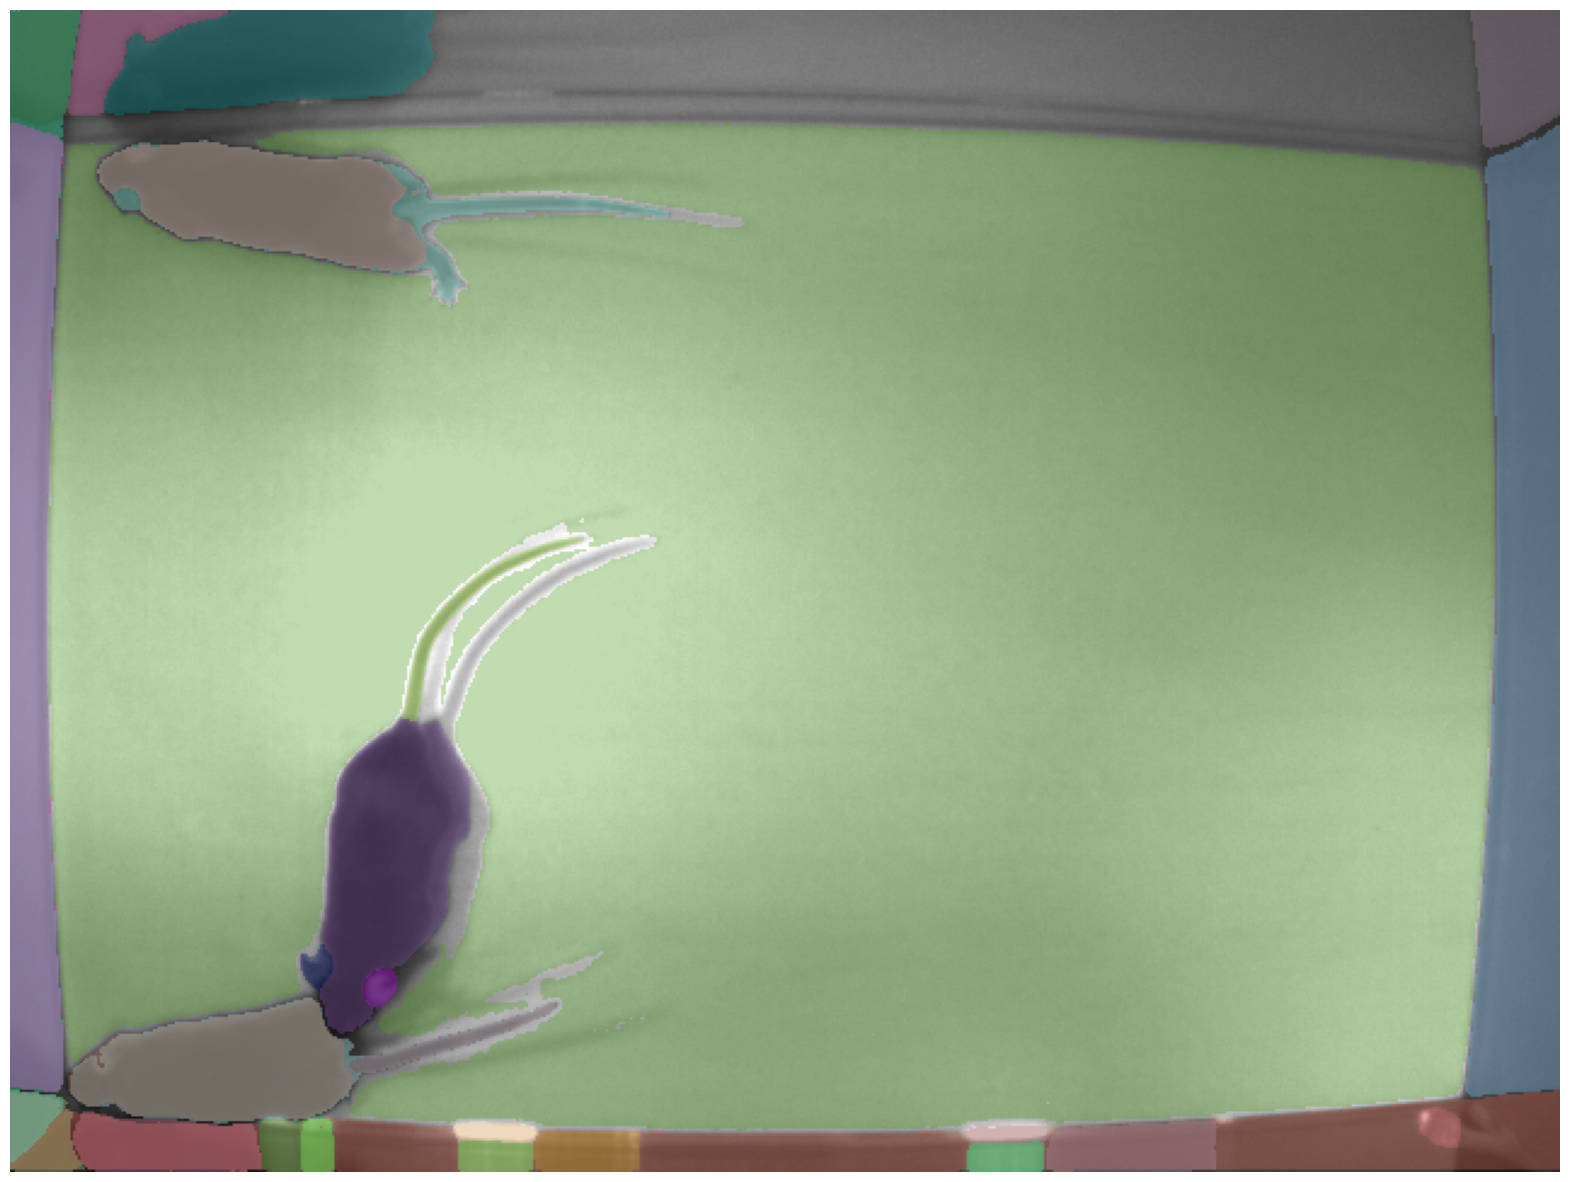

In [55]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis("off")
plt.show()

In [ ]:
import locale

locale.getpreferredencoding = lambda: "UTF-8"
!git clone --recurse-submodules https://github.com/healthonrails/yolov8_tracking.git

In [ ]:
%pip install ultralytics

In [23]:
%cd /content/GroundingDINO/yolov8_tracking/
%pip install -qr requirements.txt

/content/GroundingDINO/yolov8_tracking


In [24]:
from trackers.multi_tracker_zoo import create_tracker

In [25]:
tracking_method = "ocsort"
tracking_config = f"/content/GroundingDINO/yolov8_tracking/trackers/{tracking_method}/configs/{tracking_method}.yaml"
reid_weights = "osnet_x0_25_msmt17.pt"
device = 0
half = True
tracker = create_tracker(tracking_method, tracking_config, reid_weights, device, half)

In [26]:
if hasattr(tracker, "model"):
    if hasattr(tracker.model, "warmup"):
        tracker.model.warmup()

In [27]:
import numpy as np

In [59]:
def convert_bboxes(boxes, logits):
    bboxes = []
    for box, class_score in zip(boxes, logits):
        box = list(box.cpu().numpy())
        box.append(class_score.cpu().item())
        box.append(0)  # class
        bboxes.append(box)
    return np.array(bboxes)

In [60]:
from torchvision.ops import box_convert
from typing import List
import cv2


def annotate(
    image_source: np.ndarray,
    boxes: torch.Tensor,
    logits: torch.Tensor,
    phrases: List[str],
) -> np.ndarray:
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    # xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    bbox_xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy")
    xyxy = bbox_xyxy.numpy()
    detections = sv.Detections(xyxy=xyxy)
    ids = np.hstack((xyxy, logits.reshape(-1, 1), logits.reshape(-1, 1)))
    ids = tracker.update(ids, _)
    labels = [
        f"{phrase} {logit:.2f} ID:{int(id[4])}"
        for phrase, logit, id in zip(phrases, logits, ids)
    ]
    box_annotator = sv.BoxAnnotator()
    annotated_frame = cv2.cvtColor(image_source, cv2.COLOR_RGB2BGR)
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels
    )
    return annotated_frame

## Grounding DINO Demo

In [ ]:
import os
import supervision as sv

IMAGE_NAME = "/content/birds_dance_bbc_000002754.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "bird dance,beak,bird body"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
)

annotated_frame = annotate(
    image_source=image_source, boxes=boxes, logits=logits, phrases=phrases
)

%matplotlib inline  
sv.show_frame_in_notebook(annotated_frame, (16, 16))

##Grounding DINO + SAM Demo on Videos

Processed frame number:  0


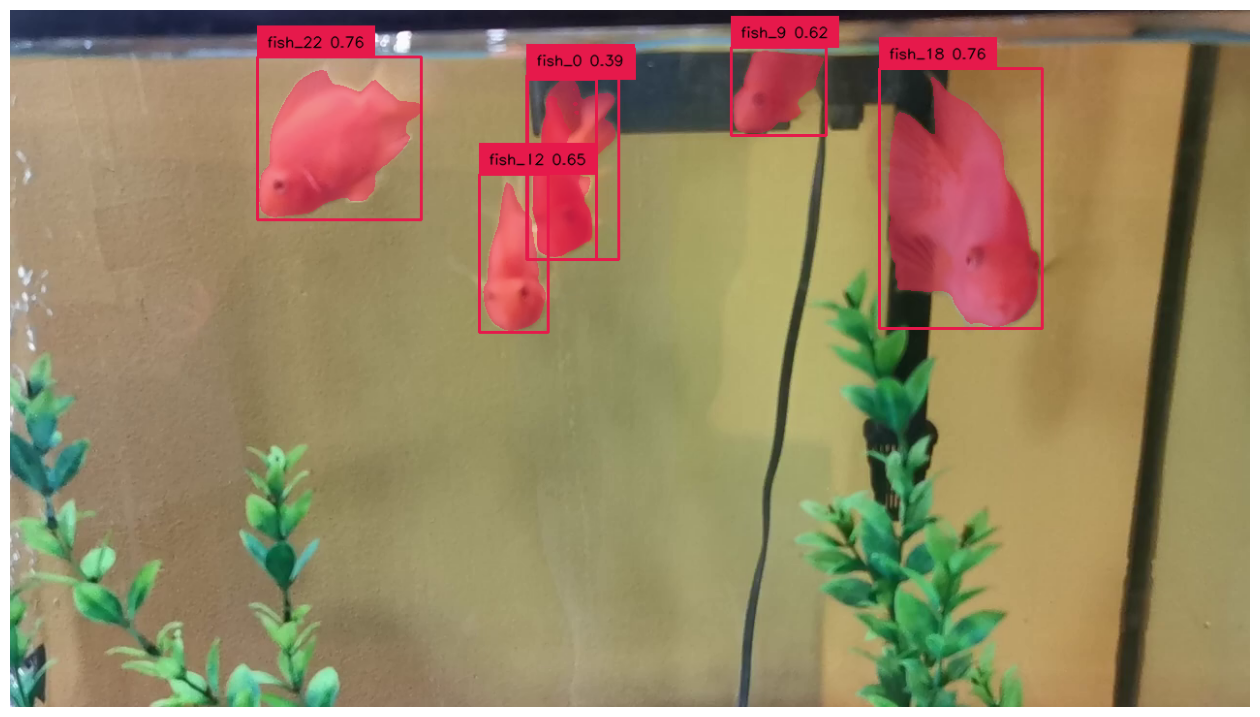

Processed frame number:  100


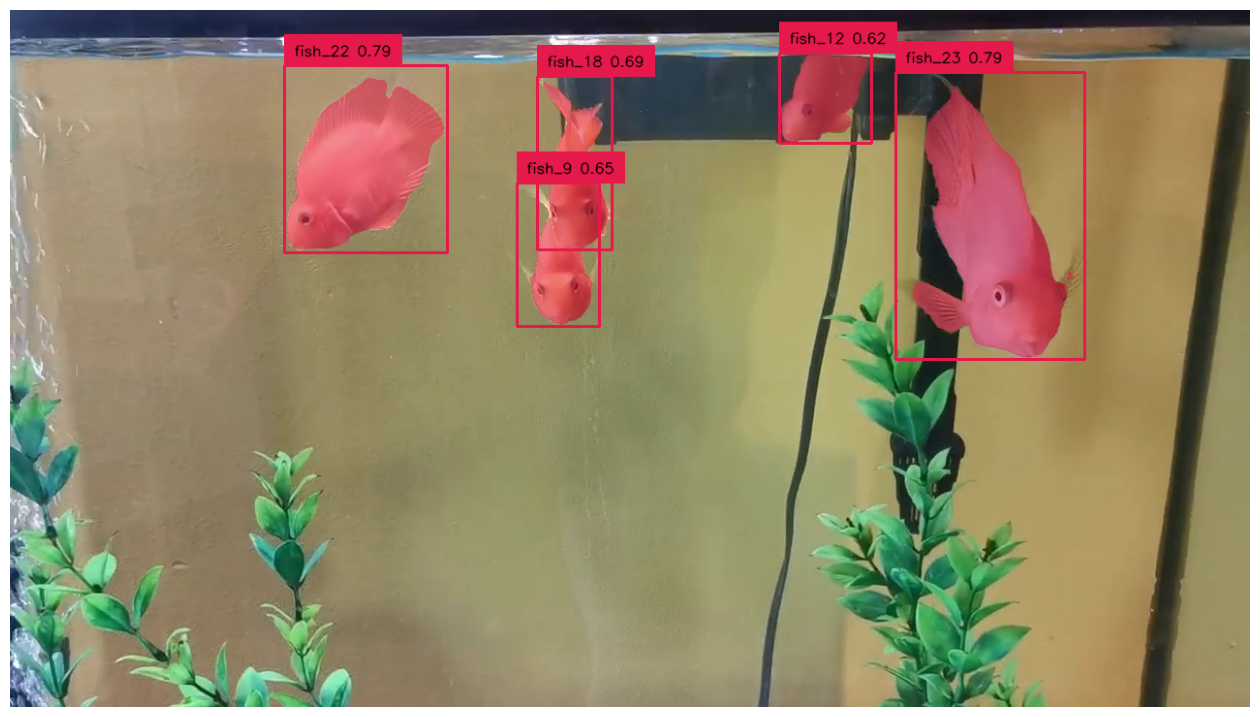

Processed frame number:  200


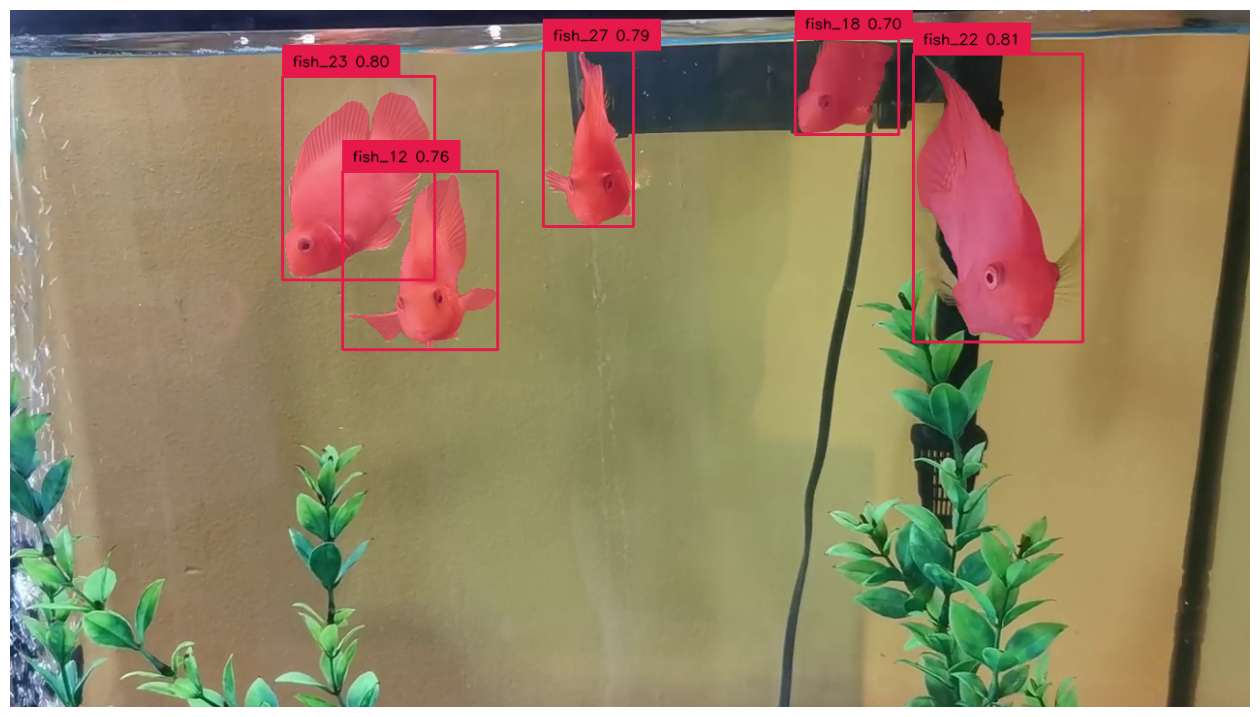

Processed frame number:  300


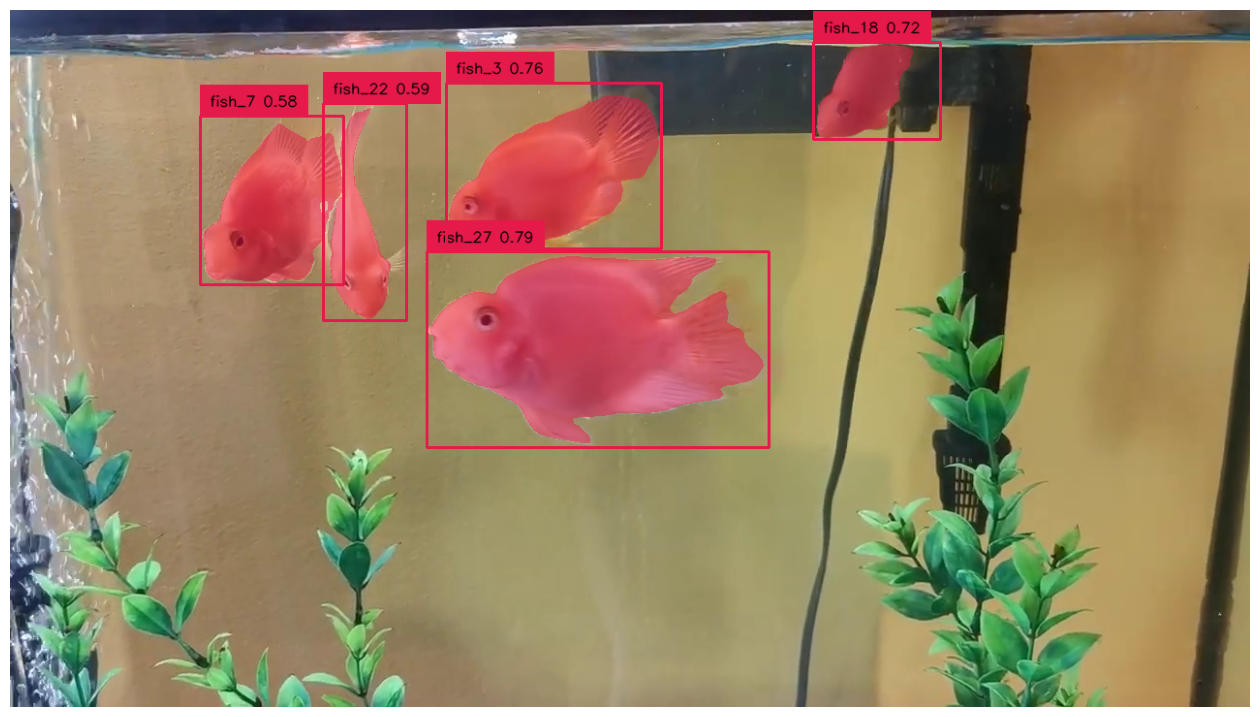

Processed frame number:  400


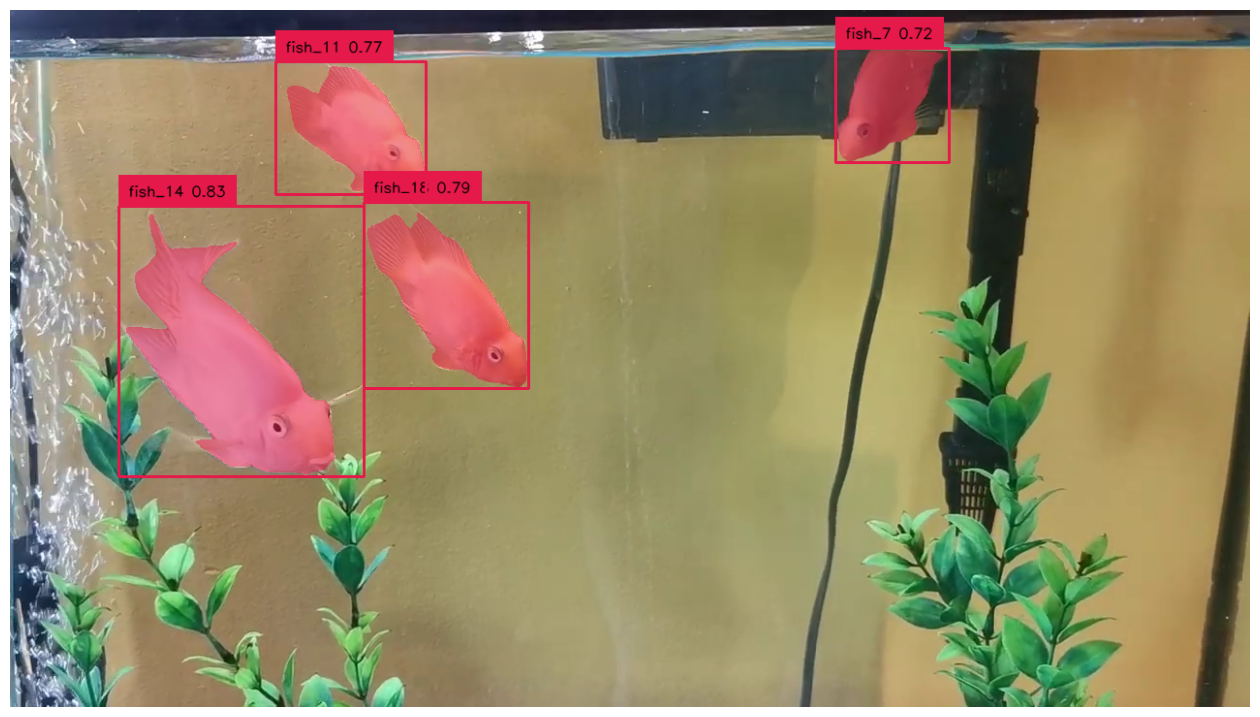

Processed frame number:  500


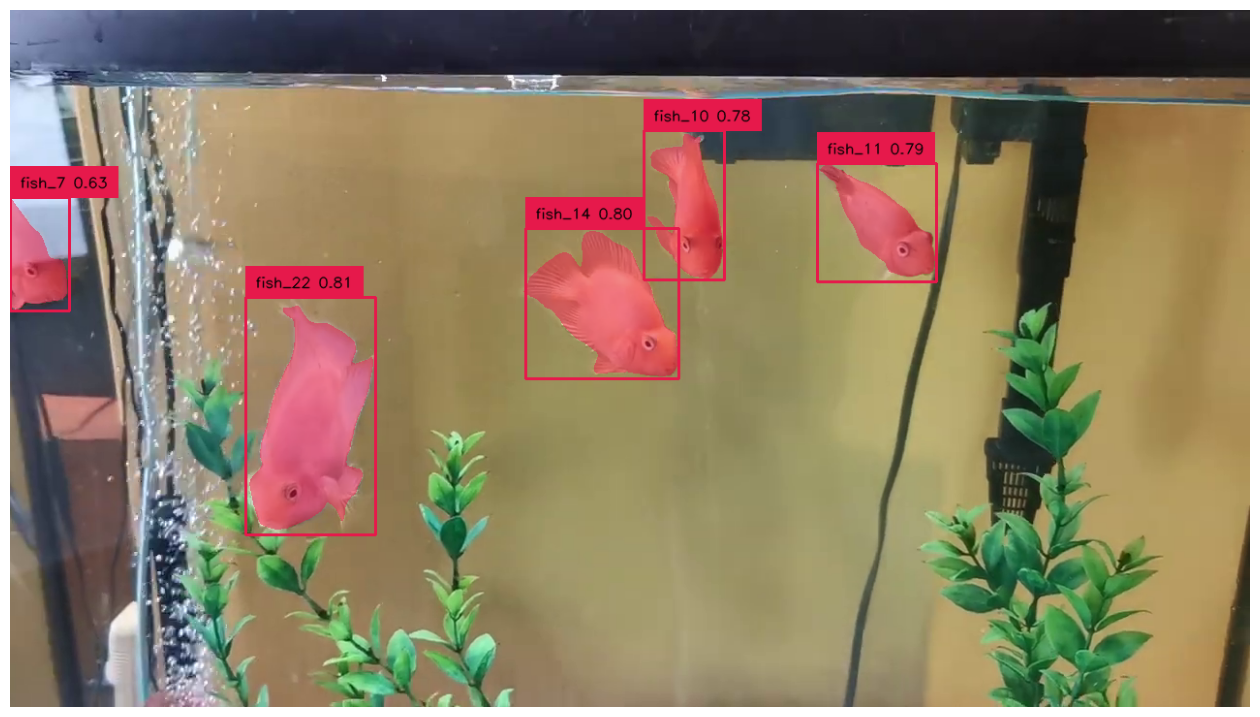

Processed frame number:  600


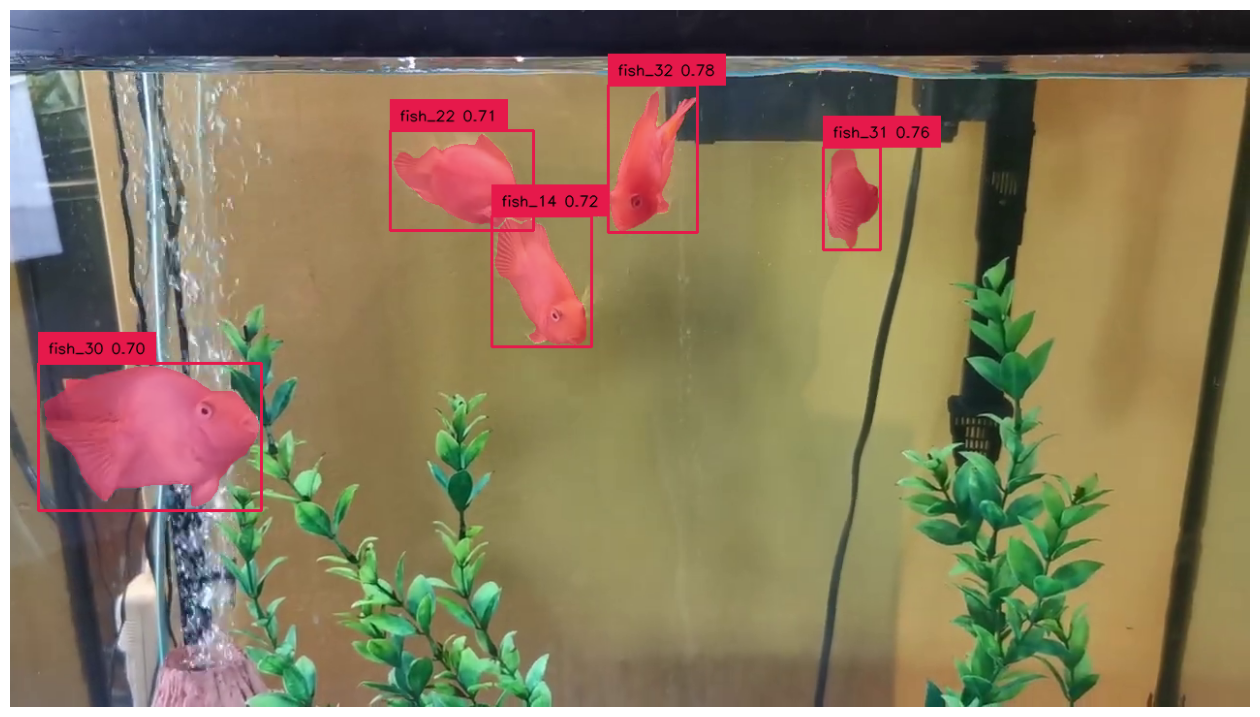

In [35]:
import cv2

CLASS = "fish"  # @param
VIDEO_FILE = "/content/fish.mp4"  # @param
BOX_TRESHOLD = 0.35  # @param
TEXT_TRESHOLD = 0.25  # @param
# Open the video file
vidcap = cv2.VideoCapture(VIDEO_FILE)
# Get the video dimensions and FPS
width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(vidcap.get(cv2.CAP_PROP_FPS))

# Define the output video file
out = cv2.VideoWriter(
    VIDEO_FILE.replace(".mp4", "_output.mp4"),
    cv2.VideoWriter_fourcc(*"MP4V"),
    fps,
    (width, height),
    isColor=True,
)

counter = 0
# Read the first frame
success, image = vidcap.read()
skip_frames = 10  # @param
# Loop through the frames
while success:
    if counter % skip_frames:
        success, image = vidcap.read()
        counter += 1
        continue
    # detect objects
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD,
    )
    # convert detections to masks
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy,
    )
    xyxy = detections.xyxy
    logits = detections.confidence
    ids = np.hstack((xyxy, logits.reshape(-1, 1), logits.reshape(-1, 1)))
    ids = tracker.update(torch.from_numpy(ids), _)

    # annotate image with detections and masks
    # box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()
    labels = [
        f"{CLASSES[class_id]}_{int(ids[i][4]) if i < len(ids) else 0} {confidence:0.2f}"
        for i, (_, _, confidence, class_id, _) in enumerate(detections)
    ]
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(
        scene=annotated_image, detections=detections, labels=labels
    )
    out.write(annotated_image)
    if counter % 100 == 0:
        print("Processed frame number: ", counter)
        sv.plot_image(annotated_image, (16, 16))
    # Wait for a key press (in milliseconds)
    # Adjust the delay time to control the playback speed
    key = cv2.waitKey(25)
    # Exit the loop if the 'q' key is pressed
    if key == ord("q"):
        break
    # Read the next frame
    success, image = vidcap.read()
    counter += 1
# Release the video file and close the window
vidcap.release()
out.release()
cv2.destroyAllWindows()